In [ ]:
# Import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


# New Section

In [ ]:
# Download Tesla (TSLA) stock data
data = yf.download("TSLA", start="2015-01-01", end="2023-01-01")
data = data[['Close']]  # Keep only the 'Close' column


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Scale data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [ ]:
# Create a dataset with 60 days of data for each training sample
def create_dataset(data, time_step=60):
    x, y = [], []
    for i in range(len(data) - time_step - 1):
        x.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(x), np.array(y)

time_step = 60
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# Reshape input for LSTM [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)


In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 0.0088 - val_loss: 0.0057
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 8.1845e-04 - val_loss: 0.0050
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 6.8581e-04 - val_loss: 0.0047
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 6.4840e-04 - val_loss: 0.0041
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 4.5495e-04 - val_loss: 0.0053
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 5.1276e-04 - val_loss: 0.0036
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 4.6427e-04 - val_loss: 0.0059
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 5.0514e-04 - val_loss: 0.0033
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 5.2001e-04 - val_loss: 0.0063
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 6.6567e-04 - val_loss: 0.0033
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 4.6844e-04 - val_loss: 0.0044
Epoch 12/20
49/49 ━━━━━

In [ ]:
# Make predictions
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Inverse transform to get the actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


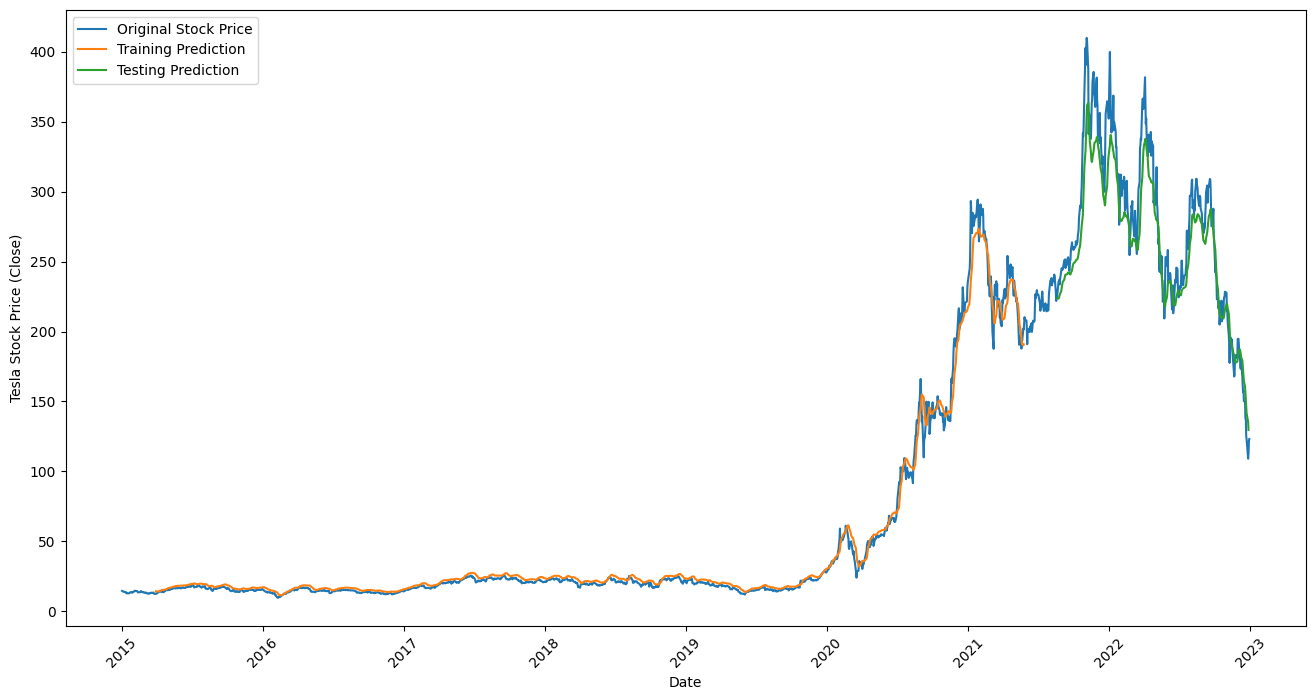

In [ ]:
# Prepare data for visualization
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan

# Correct the start index for test predictions
test_start_index = len(train_predict) + (time_step * 2)
test_plot[test_start_index:test_start_index + len(test_predict), :] = test_predict

# Plot with actual dates on the x-axis
plt.figure(figsize=(16, 8))
plt.plot(data.index, scaler.inverse_transform(scaled_data), label='Original Stock Price')  # Original data
plt.plot(data.index, train_plot, label='Training Prediction')  # Train predictions
plt.plot(data.index, test_plot, label='Testing Prediction')    # Test predictions
plt.xlabel('Date')
plt.ylabel('Tesla Stock Price (Close)')
plt.legend()
plt.xticks(rotation=45)
plt.show()
